In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Reading 

import os
from glob import glob
from PIL import Image

# Data Processing 

import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A

# Data Analysis

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import keras
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,AveragePooling2D, Activation, BatchNormalization
from tensorflow.keras.utils import to_categorical,image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
levels = ['Normal', 'COVID','Pneumonia']
path = "covid_19_min/"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level,'images')):
        data.append(['{}/{}/{}'.format(level,'images' ,file), level])

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal': 'Negative', 'COVID': 'Positive','Pneumonia':'Pneumonia'})
samples = 15153

data.head()

,image_file,corona_result,path
0,Normal/images/Normal-30.png,Negative,covid_19_min//Normal/images/Normal-30.png
1,Normal/images/Normal-160.png,Negative,covid_19_min//Normal/images/Normal-160.png
2,Normal/images/Normal-112.png,Negative,covid_19_min//Normal/images/Normal-112.png
3,Normal/images/Normal-366.png,Negative,covid_19_min//Normal/images/Normal-366.png
4,Normal/images/Normal-362.png,Negative,covid_19_min//Normal/images/Normal-362.png


In [ ]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))

Number of Duplicated Samples: 0
Number of Total Samples: 1500


# Exploratory Data Analysis 

### 1. Count Plot 

In [ ]:
df = pd.DataFrame()
df['corona_result'] = ['Positive', 'Negative','Pneumonia']
df['Count'] = [len(data[data['corona_result'] == 'Positive']), len(data[data['corona_result'] == 'Negative']),len(data[data['corona_result'] == 'Pneumonia'])]
df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'corona_result', y = 'Count', 
             color = "corona_result", text_auto='', width = 600, 
             color_discrete_sequence = ["orange", "purple","Green"],
             template = 'plotly_dark')

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

### 2. Image Samples

In [ ]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

data.head()

,image_file,corona_result,path,image
0,Normal/images/Normal-30.png,Negative,covid_19_min//Normal/images/Normal-30.png,"[[10, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, ..."
1,Normal/images/Normal-160.png,Negative,covid_19_min//Normal/images/Normal-160.png,"[[34, 46, 52, 53, 52, 57, 65, 69, 81, 115, 127..."
2,Normal/images/Normal-112.png,Negative,covid_19_min//Normal/images/Normal-112.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,Normal/images/Normal-366.png,Negative,covid_19_min//Normal/images/Normal-366.png,"[[37, 38, 38, 41, 42, 38, 30, 34, 37, 38, 36, ..."
4,Normal/images/Normal-362.png,Negative,covid_19_min//Normal/images/Normal-362.png,"[[45, 74, 90, 105, 118, 123, 121, 122, 123, 11..."


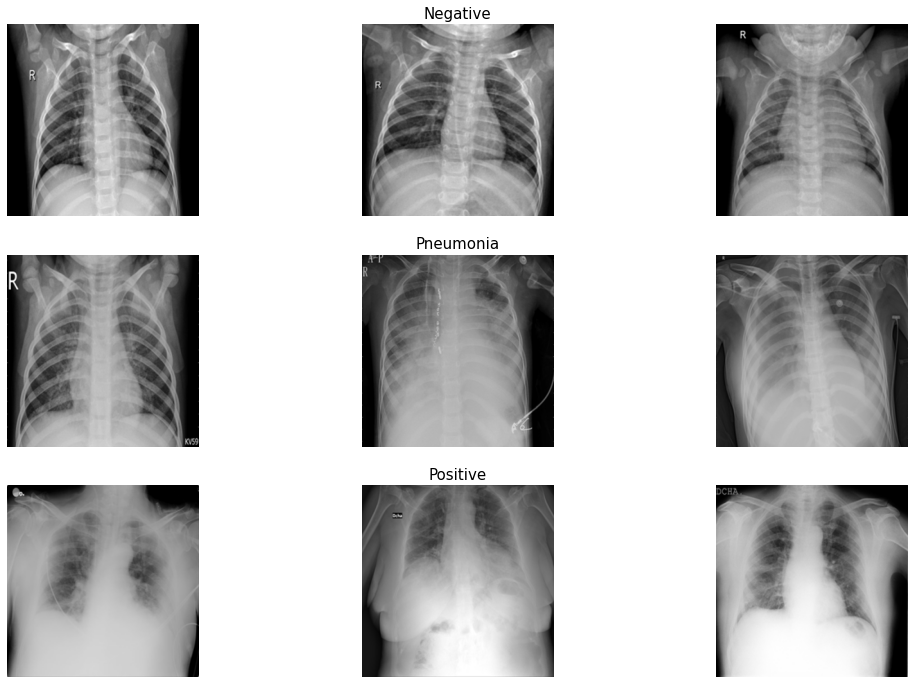

In [ ]:
n_samples = 3

fig, m_axs = plt.subplots(3, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['corona_result']).groupby('corona_result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

### 3.Image Value Distribution

In [ ]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0, 1500):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image','corona_result','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

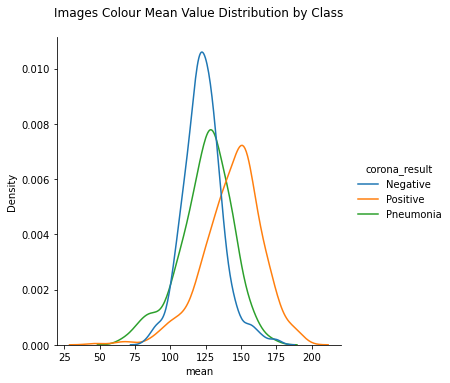

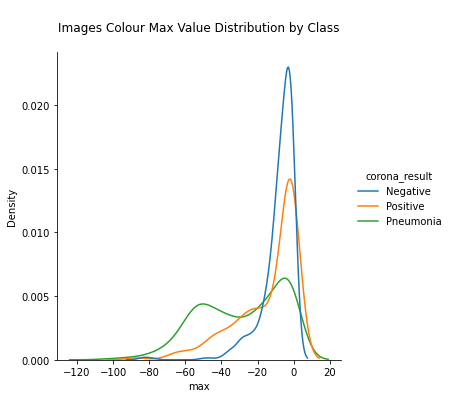

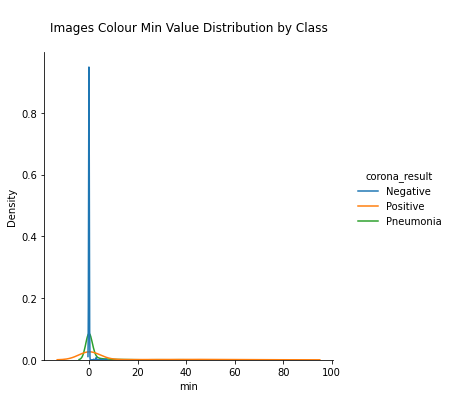

In [ ]:
ax1 = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'corona_result');
plt.title('Images Colour Mean Value Distribution by Class\n', fontsize = 12);

ax2 = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'corona_result');
plt.title('\nImages Colour Max Value Distribution by Class\n', fontsize = 12);

ax3 = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'corona_result');
plt.title('\nImages Colour Min Value Distribution by Class\n', fontsize = 12);

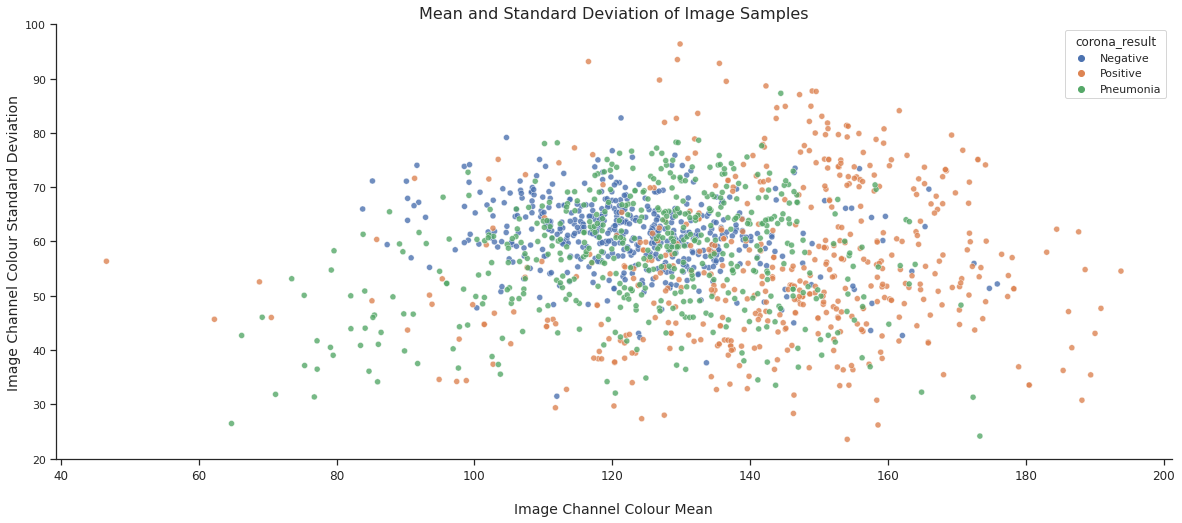

In [ ]:
plt.figure(figsize = (20, 8))
sns.set(style = "ticks", font_scale = 1)
ax = sns.scatterplot(data = imageEDA, x = "mean", y = imageEDA['stedev'], hue = 'corona_result', alpha = 0.8);
sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
ax.set_xlabel('\nImage Channel Colour Mean', fontsize = 14)
ax.set_ylabel('Image Channel Colour Standard Deviation', fontsize = 14)
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16);

<Figure size 720x576 with 0 Axes>

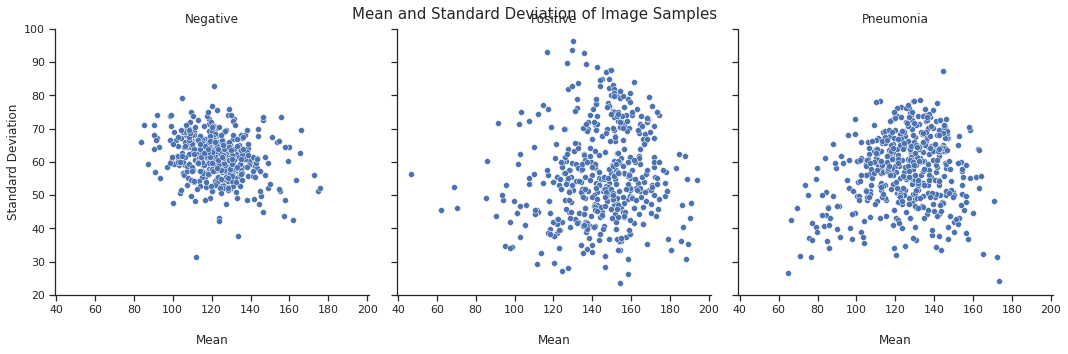

In [ ]:
plt.figure(figsize = (10, 8));
g = sns.FacetGrid(imageEDA, col = "corona_result", height = 5);
g.map_dataframe(sns.scatterplot, x = 'mean', y = 'stedev');
g.set_titles(col_template = "{col_name}", row_template= "{row_name}", size = 12);
g.fig.subplots_adjust(top = .7);
g.fig.suptitle('Mean and Standard Deviation of Image Samples', fontsize = 15);
axes = g.axes.flatten();
axes[0].set_ylabel('Standard Deviation');
for ax in axes:
    ax.set_xlabel('\nMean');
g.fig.tight_layout();

### Preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.25)

In [ ]:
from sklearn.utils import shuffle
train_generator = train_datagen.flow_from_directory('/content/covid_19_min',
                                                             target_size = (224,224),
                                                             subset = 'training',
                                                    batch_size=1500,
                                                    shuffle = True)
validation_generator = train_datagen.flow_from_directory('/content/covid_19_min',
                                                                  target_size = (224,224),
                                                                  subset = 'validation',
                                                         batch_size=1500,
                                                         shuffle = True)

Found 1125 images belonging to 3 classes.
Found 375 images belonging to 3 classes.


In [ ]:
train_generator.class_indices

{'COVID': 0, 'Normal': 1, 'Pneumonia': 2}

In [ ]:
x_train,y_train = next(train_generator)
x_test,y_test = next(validation_generator)

In [ ]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(1125, 224, 224, 3) (375, 224, 224, 3) (1125, 3) (375, 3)


### Training

###VGG16 Model

In [ ]:
img_shape = (224,224,3)

In [ ]:
baseModel = tf.keras.applications.VGG16(input_shape=(224,224,3),weights='imagenet',include_top=False)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in baseModel.layers:
  layer.trainable=False

In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

model1 = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model1.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,epochs=50)

Epoch 1/50
36/36 [==============================] - 11s 298ms/step - loss: 0.8765 - accuracy: 0.6240 - val_loss: 0.6185 - val_accuracy: 0.8747
Epoch 2/50
36/36 [==============================] - 7s 207ms/step - loss: 0.5305 - accuracy: 0.8480 - val_loss: 0.4404 - val_accuracy: 0.8880
Epoch 3/50
36/36 [==============================] - 7s 209ms/step - loss: 0.3990 - accuracy: 0.8889 - val_loss: 0.3547 - val_accuracy: 0.9120
Epoch 4/50
36/36 [==============================] - 7s 207ms/step - loss: 0.3443 - accuracy: 0.9049 - val_loss: 0.3046 - val_accuracy: 0.9200
Epoch 5/50
36/36 [==============================] - 7s 208ms/step - loss: 0.2912 - accuracy: 0.9182 - val_loss: 0.2948 - val_accuracy: 0.9067
Epoch 6/50
36/36 [==============================] - 8s 212ms/step - loss: 0.2575 - accuracy: 0.9280 - val_loss: 0.2522 - val_accuracy: 0.9227
Epoch 7/50
36/36 [==============================] - 8s 214ms/step - loss: 0.2430 - accuracy: 0.9280 - val_loss: 0.2437 - val_accuracy: 0.9227
Epoch

In [ ]:
model1.save('ensemble_models/vgg_16.hdf5')

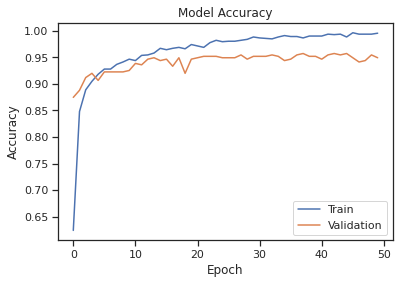

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

## DenseNet

In [ ]:
dense_model = tf.keras.applications.DenseNet201(input_shape=(224,224,3),weights='imagenet',include_top=False)

74836368/74836368 [==============================] - 3s 0us/step


In [ ]:
for layer in dense_model.layers:
  layer.trainable=False

In [ ]:
headModel = dense_model.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

model2 = Model(inputs=dense_model.input, outputs=headModel)

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
dense_history = model2.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,epochs=50)

Epoch 1/50
36/36 [==============================] - 29s 416ms/step - loss: 0.4376 - accuracy: 0.8320 - val_loss: 0.3005 - val_accuracy: 0.8827
Epoch 2/50
36/36 [==============================] - 8s 222ms/step - loss: 0.1397 - accuracy: 0.9511 - val_loss: 0.2065 - val_accuracy: 0.9173
Epoch 3/50
36/36 [==============================] - 7s 201ms/step - loss: 0.0904 - accuracy: 0.9698 - val_loss: 0.2343 - val_accuracy: 0.9227
Epoch 4/50
36/36 [==============================] - 7s 199ms/step - loss: 0.0648 - accuracy: 0.9787 - val_loss: 0.2136 - val_accuracy: 0.9253
Epoch 5/50
36/36 [==============================] - 7s 197ms/step - loss: 0.0344 - accuracy: 0.9938 - val_loss: 0.2066 - val_accuracy: 0.9280
Epoch 6/50
36/36 [==============================] - 8s 221ms/step - loss: 0.0325 - accuracy: 0.9938 - val_loss: 0.1859 - val_accuracy: 0.9333
Epoch 7/50
36/36 [==============================] - 7s 195ms/step - loss: 0.0208 - accuracy: 0.9973 - val_loss: 0.2161 - val_accuracy: 0.9280
Epoch

In [ ]:
model2.save('ensemble_models/densenet.hdf5')

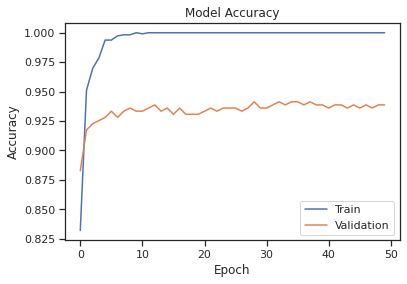

In [ ]:
plt.plot(dense_history.history['accuracy'])
plt.plot(dense_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

## MobileNet

In [ ]:
mobile_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),weights='imagenet',include_top=False)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
for layer in mobile_model.layers:
  layer.trainable=False

In [ ]:
headModel = mobile_model.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

model3 = Model(inputs=mobile_model.input, outputs=headModel)

In [ ]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
mobile_history = model3.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,epochs=50)

Epoch 1/50
36/36 [==============================] - 7s 103ms/step - loss: 0.4725 - accuracy: 0.8204 - val_loss: 0.2319 - val_accuracy: 0.9093
Epoch 2/50
36/36 [==============================] - 2s 61ms/step - loss: 0.1557 - accuracy: 0.9511 - val_loss: 0.2264 - val_accuracy: 0.9093
Epoch 3/50
36/36 [==============================] - 2s 60ms/step - loss: 0.1009 - accuracy: 0.9671 - val_loss: 0.2218 - val_accuracy: 0.9200
Epoch 4/50
36/36 [==============================] - 2s 60ms/step - loss: 0.0478 - accuracy: 0.9867 - val_loss: 0.2509 - val_accuracy: 0.9173
Epoch 5/50
36/36 [==============================] - 2s 61ms/step - loss: 0.0320 - accuracy: 0.9929 - val_loss: 0.1774 - val_accuracy: 0.9360
Epoch 6/50
36/36 [==============================] - 2s 61ms/step - loss: 0.0177 - accuracy: 0.9982 - val_loss: 0.1819 - val_accuracy: 0.9360
Epoch 7/50
36/36 [==============================] - 2s 64ms/step - loss: 0.0144 - accuracy: 0.9982 - val_loss: 0.2097 - val_accuracy: 0.9333
Epoch 8/50
3

In [ ]:
model3.save('ensemble_models/mobilenet.hdf5')

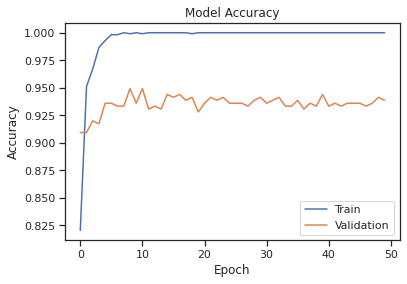

In [ ]:
plt.plot(mobile_history.history['accuracy'])
plt.plot(mobile_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

### Ensemble

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score

In [ ]:
model1 = load_model('ensemble_models/vgg_16.hdf5')
model2 = load_model('ensemble_models/densenet.hdf5')
model3 = load_model('ensemble_models/mobilenet.hdf5')

In [ ]:
models = [model1, model2, model3]

In [ ]:
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

12/12 [==============================] - 1s 41ms/step


In [ ]:
ensemble_prediction = np.argmax(summed, axis=1)

In [ ]:
prediction1 = model1.predict(x_test)
prediction2 = model2.predict(x_test)
prediction3 = model3.predict(x_test)

12/12 [==============================] - 0s 41ms/step


In [ ]:
acc1 = [np.argmax(i) for i in prediction1]
acc2 = [np.argmax(i) for i in prediction2]
acc3 = [np.argmax(i) for i in prediction3]

In [ ]:
y_test_pred = [np.argmax(i) for i in y_test]

In [ ]:
accuracy1 = accuracy_score(y_test_pred, acc1)
accuracy2 = accuracy_score(y_test_pred, acc2)
accuracy3 = accuracy_score(y_test_pred, acc3)
ensemble_accuracy = accuracy_score(y_test_pred, ensemble_prediction)

In [ ]:
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

Accuracy Score for model1 =  0.9493333333333334
Accuracy Score for model2 =  0.9386666666666666
Accuracy Score for model3 =  0.9386666666666666
Accuracy Score for average ensemble =  0.952


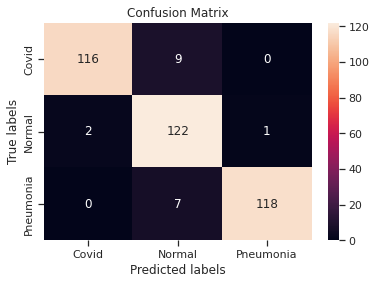

In [ ]:
cm1 = confusion_matrix(y_test_pred,acc1)
 

ax= plt.subplot()
sns.heatmap(cm1, annot=True, fmt='g', ax=ax);  


ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Covid', 'Normal','Pneumonia']); ax.yaxis.set_ticklabels(['Covid', 'Normal','Pneumonia']);

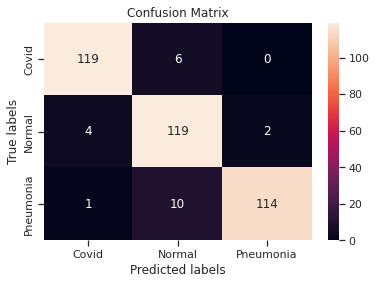

In [ ]:
cm2 = confusion_matrix(y_test_pred,acc2)
 

ax= plt.subplot()
sns.heatmap(cm2, annot=True, fmt='g', ax=ax);  


ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Covid', 'Normal','Pneumonia']); ax.yaxis.set_ticklabels(['Covid', 'Normal','Pneumonia']);

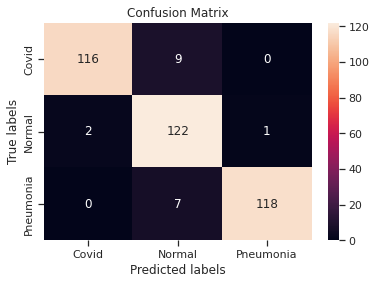

In [ ]:
cm3 = confusion_matrix(y_test_pred,acc3)
 

ax= plt.subplot()
sns.heatmap(cm1, annot=True, fmt='g', ax=ax);  


ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Covid', 'Normal','Pneumonia']); ax.yaxis.set_ticklabels(['Covid', 'Normal','Pneumonia']);

In [ ]:
cr1 = classification_report(y_test_pred,acc1)
cr1

'              precision    recall  f1-score   support\n\n           0       0.98      0.93      0.95       125\n           1       0.88      0.98      0.93       125\n           2       0.99      0.94      0.97       125\n\n    accuracy                           0.95       375\n   macro avg       0.95      0.95      0.95       375\nweighted avg       0.95      0.95      0.95       375\n'

In [ ]:
cr2 = classification_report(y_test_pred,acc2)
cr2

'              precision    recall  f1-score   support\n\n           0       0.96      0.95      0.96       125\n           1       0.88      0.95      0.92       125\n           2       0.98      0.91      0.95       125\n\n    accuracy                           0.94       375\n   macro avg       0.94      0.94      0.94       375\nweighted avg       0.94      0.94      0.94       375\n'

In [ ]:
cr3 = classification_report(y_test_pred,acc3)
cr3

'              precision    recall  f1-score   support\n\n           0       0.96      0.95      0.96       125\n           1       0.89      0.97      0.93       125\n           2       0.97      0.90      0.93       125\n\n    accuracy                           0.94       375\n   macro avg       0.94      0.94      0.94       375\nweighted avg       0.94      0.94      0.94       375\n'

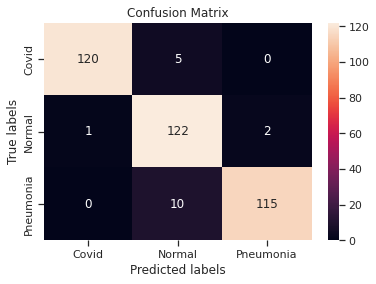

In [ ]:
cm_ensemble = confusion_matrix(y_test_pred,ensemble_prediction)
 

ax= plt.subplot()
sns.heatmap(cm_ensemble, annot=True, fmt='g', ax=ax);  


ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Covid', 'Normal','Pneumonia']); ax.yaxis.set_ticklabels(['Covid', 'Normal','Pneumonia']);

In [ ]:
cr4 = classification_report(y_test_pred,ensemble_prediction)
cr4

'              precision    recall  f1-score   support\n\n           0       0.99      0.96      0.98       125\n           1       0.89      0.98      0.93       125\n           2       0.98      0.92      0.95       125\n\n    accuracy                           0.95       375\n   macro avg       0.96      0.95      0.95       375\nweighted avg       0.96      0.95      0.95       375\n'

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
acc_graph = accuracy_score(y_test_pred,ensemble_prediction)
results_all = precision_recall_fscore_support(y_test_pred,ensemble_prediction,average='macro')

results_class = precision_recall_fscore_support(y_test_pred, ensemble_prediction, average=None)

In [ ]:
metric_columns = ['Precision','Recall', 'F-Score','S']

In [ ]:
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID','Normal', 'Viral Pneumonia','Total']

In [ ]:
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');

**Overall Results**
Accuracy Result: 95.20%
Precision Result: 95.51%
Recall Result: 95.20%
F-Score Result: 95.24%


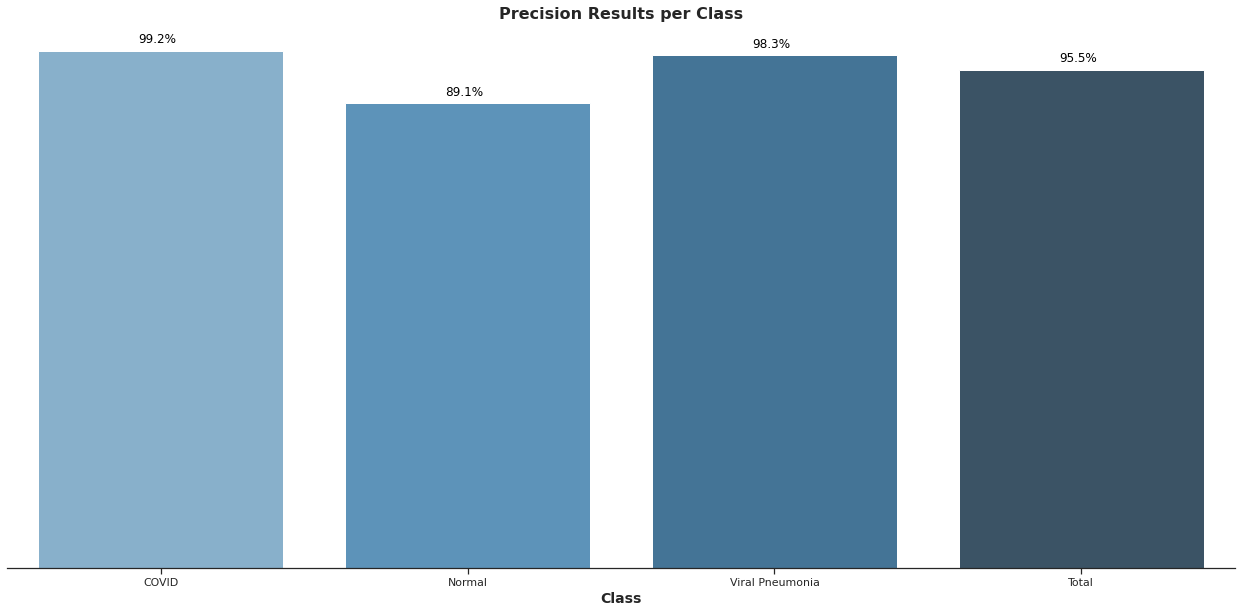

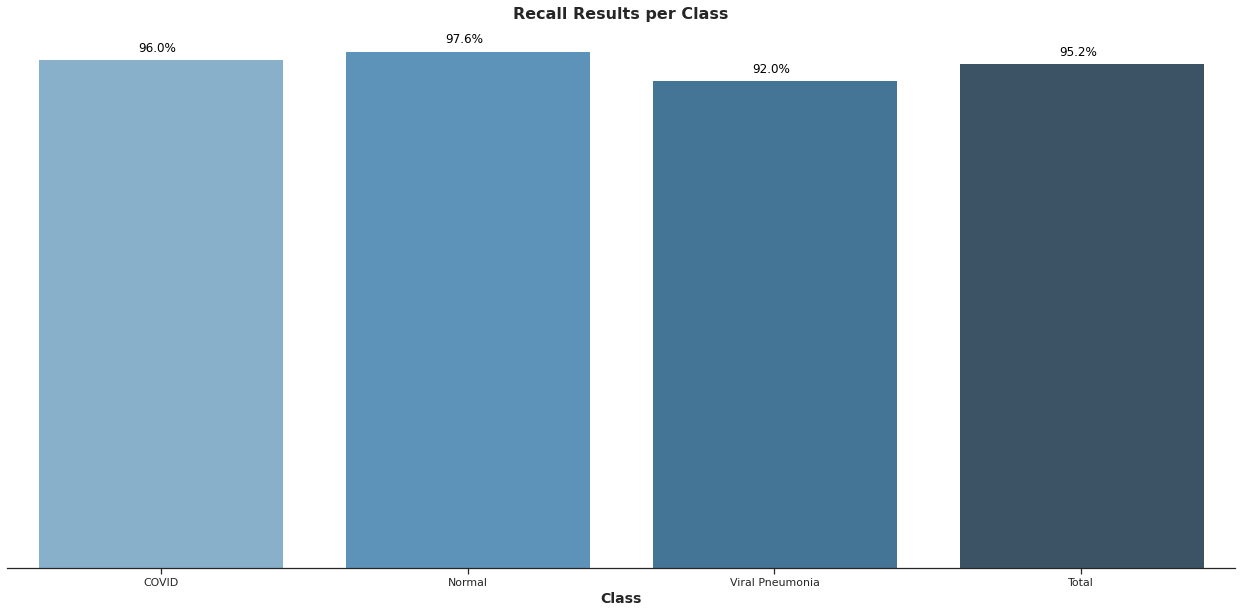

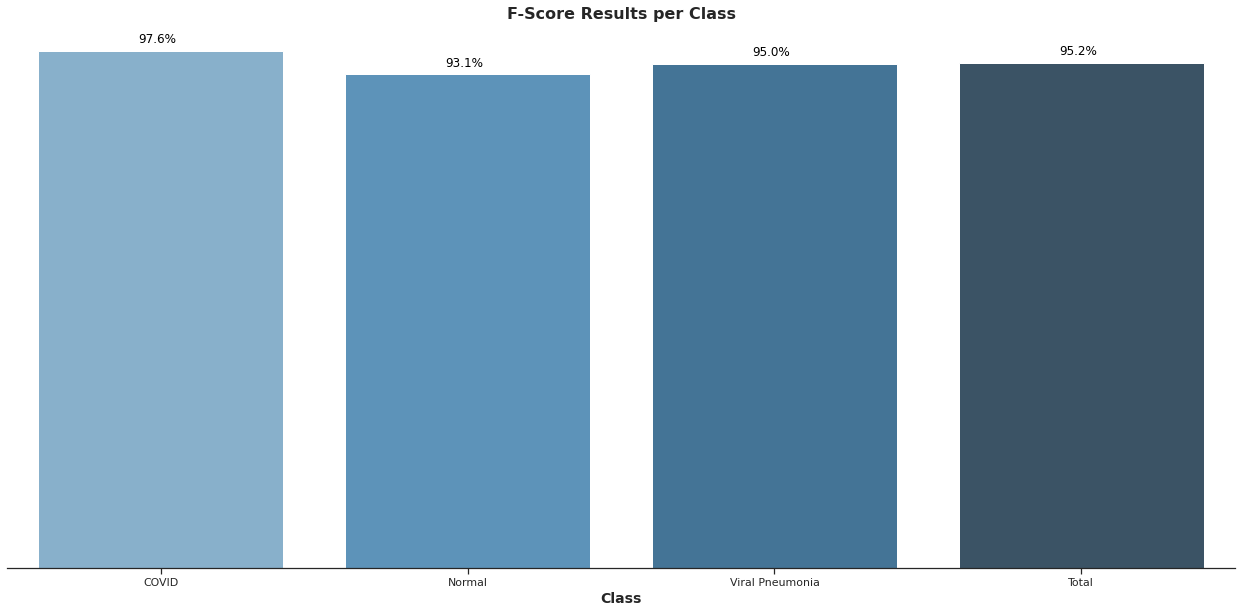

In [ ]:
metrics_plot(all_df, 'Precision')
metrics_plot(all_df, 'Recall')
metrics_plot(all_df, 'F-Score')
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc_graph*100))
print('Precision Result: %.2f%%'%(all_df.iloc[3,0]*100))
print('Recall Result: %.2f%%'%(all_df.iloc[3,1]*100))
print('F-Score Result: %.2f%%'%(all_df.iloc[3,2]*100))

In [ ]:
from sklearn.metrics import precision_recall_curve,roc_curve

In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

In [ ]:
y_test_pred_multi = lb.fit_transform(y_test_pred)

In [ ]:
ensemble_pred_multi = lb.fit_transform(ensemble_prediction)

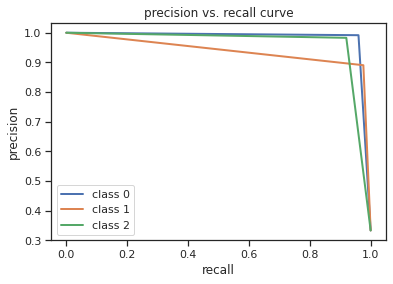

In [ ]:
precision = dict()
recall = dict()

for i in range(3):
  precision[i],recall[i],_ = precision_recall_curve(y_test_pred_multi[:, i],ensemble_pred_multi[:, i])
  plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

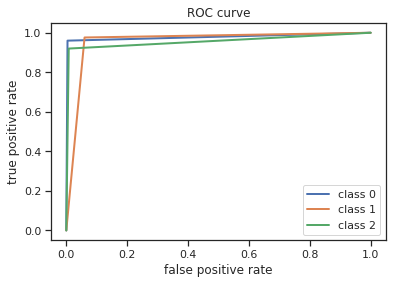

In [ ]:
fpr = dict()
tpr = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_pred_multi[:, i],ensemble_pred_multi[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

### Weighted Ensemble

In [ ]:
models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
weights = [0.4, 0.3, 0.3]

12/12 [==============================] - 0s 39ms/step


In [ ]:
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

In [ ]:
weighted_accuracy = accuracy_score(y_test_pred, weighted_ensemble_prediction)

In [ ]:
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for weighted average ensemble =  0.9466666666666667
